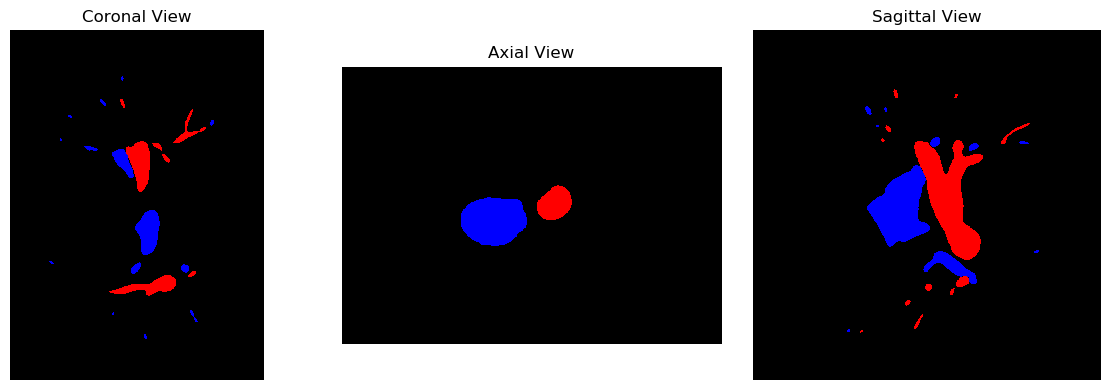

In [3]:
# [FUNCTIONAL - USE] Generates image of central coronal, axial, and sagittal views of labelmap (not segmentations) for label verification

# STRUCTURES SHOULD BE AS FOLLOWS:

# Label 0 - black (background)
# Label 1 - blue (artery)
# Label 2 - red (vein)

import numpy as np
import nrrd
import matplotlib.pyplot as plt

# Loads the '.nrrd' file
file_path = 'C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Final-2-label.nrrd'
data, header = nrrd.read(file_path)

# Selects the middle slices from the dataset
coronal_slice_index = data.shape[2] // 2
axial_slice_index = data.shape[0] // 2
sagittal_slice_index = data.shape[1] // 2

coronal_slice = data[:, :, coronal_slice_index]
axial_slice = data[axial_slice_index, :, :]
sagittal_slice = data[:, sagittal_slice_index, :]

# Creates colored slices 
def create_colored_slice(slice_data):
    # Set segmentation values of 1 to blue, values of 2 to red, and values of 0 to black
    colored_slice = np.zeros(slice_data.shape + (3,), dtype=np.uint8)
    colored_slice[slice_data == 1] = [0, 0, 255]  # Blue
    colored_slice[slice_data == 2] = [255, 0, 0]  # Red
    return colored_slice

colored_coronal_slice = create_colored_slice(coronal_slice)
colored_axial_slice = create_colored_slice(axial_slice)
colored_sagittal_slice = create_colored_slice(sagittal_slice)

# Displays the slices
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(colored_coronal_slice)
plt.title('Coronal View')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(colored_axial_slice)
plt.title('Axial View')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(colored_sagittal_slice)
plt.title('Sagittal View')
plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\Adam\AppData\Local\Temp\ipykernel_8176\1186791344.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if   value == '0.847059 0.396078 0.309804':
C:\Users\Adam\AppData\Local\Temp\ipykernel_8176\1186791344.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif value == '0 0.592157 0.807843':


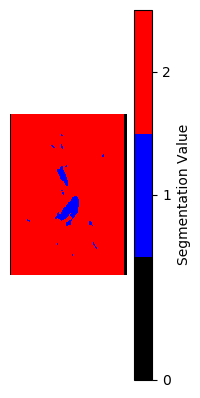

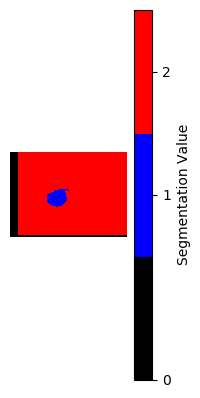

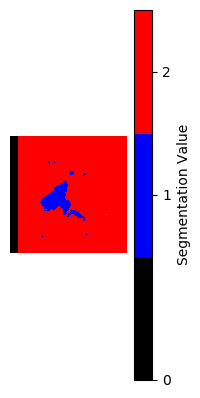

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [56]:
# [USE THIS - FUNCTIONAL]

import numpy as np
import nrrd
import matplotlib.pyplot as plt

# Load the .nrrd file
file_path = 'C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-1.nrrd'
out_file = 'C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-1_outputTest.nrrd'
data, header = nrrd.read(file_path)


# Outputs header key/value list
for key, value in header.items():
    if   value == '0.847059 0.396078 0.309804': 
        VValue = header[key[0:-6] + '_LabelValue']
    elif value == '0 0.592157 0.807843': 
        AValue = header[key[0:-6] + '_LabelValue']

outputlabelmap = np.zeros_like(data)
outputlabelmap[np.equal(data, int(AValue))] = 1
outputlabelmap[np.equal(data, int(VValue))] = 2


######################################################

# TESTING CODE FOR PRINTING CENTER VIEW OF AXIAL, CORONAL, SAGITTAL VIEWS OF LABELMAPS

# # Select the middle slices
# coronal_slice_index = data.shape[2] // 2
# axial_slice_index = data.shape[0] // 2
# sagittal_slice_index = data.shape[1] // 2

# coronal_slice = data[:, :, coronal_slice_index]
# axial_slice = data[axial_slice_index, :, :]
# sagittal_slice = data[:, sagittal_slice_index, :]

# # Create a colormap for visualization
# cmap = plt.cm.colors.ListedColormap(['black', 'blue', 'red'])

# # Define the boundaries for the colormap
# bounds = [0, 0.5, 1.5, 2.5]
# norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# # Display the colored slice
# plt.subplot(1, 3, 1)
# plt.imshow(coronal_slice, cmap=cmap, norm=norm)
# plt.colorbar(ticks=[0, 1, 2], label='Segmentation Value')
# plt.axis('off')
# plt.show()

# plt.subplot(1, 3, 2)
# plt.imshow(axial_slice, cmap=cmap, norm=norm)
# plt.colorbar(ticks=[0, 1, 2], label='Segmentation Value')
# plt.axis('off')
# plt.show()

# plt.subplot(1, 3, 3)
# plt.imshow(sagittal_slice, cmap=cmap, norm=norm)
# plt.colorbar(ticks=[0, 1, 2], label='Segmentation Value')
# plt.axis('off')
# plt.show()


# plt.figure(figsize=(12, 4))


###############################################

# # Print center 2d slices of axial, coronal, sagittal views
# import matplotlib.pyplot as plt

# # Select the middle slices
# coronal_slice_index = data.shape[2] // 2
# axial_slice_index = data.shape[0] // 2
# sagittal_slice_index = data.shape[1] // 2

# coronal_slice = data[:, :, coronal_slice_index]
# axial_slice = data[axial_slice_index, :, :]
# sagittal_slice = data[:, sagittal_slice_index, :]

# # Define colors for segmentation values
# colors = {
#     0: (0, 0, 0),     # Black
#     1: (0, 0, 255), # Blue
#     2: (255, 0, 0),   # Red
# }

# # Apply colors to slices
# def colorize_slice(slice_data):
#     colored_slice = np.zeros(slice_data.shape + (3,), dtype=np.uint8)
#     for value, color in colors.items():
#         colored_slice[slice_data == value] = color
#     return colored_slice

# colored_coronal_slice = colorize_slice(coronal_slice)
# colored_axial_slice = colorize_slice(axial_slice)
# colored_sagittal_slice = colorize_slice(sagittal_slice)

# # Select the middle slices
# coronal_slice_index = data.shape[2] // 2
# axial_slice_index = data.shape[0] // 2
# sagittal_slice_index = data.shape[1] // 2

# coronal_slice = data[:, :, coronal_slice_index]
# axial_slice = data[axial_slice_index, :, :]
# sagittal_slice = data[:, sagittal_slice_index, :]

# # Define colors for segmentation values
# colors = {
#     0: (0, 0, 0),     # Black
#     1: (0, 0, 255), # Blue
#     2: (255, 0, 0),   # Red
# }

# # Apply colors to slices
# def colorize_slice(slice_data):
#     colored_slice = np.zeros(slice_data.shape + (3,), dtype=np.uint8)
#     for value, color in colors.items():
#         colored_slice[slice_data == value] = color
#     return colored_slice

# # Display the slices
# colored_coronal_slice = colorize_slice(coronal_slice)
# colored_axial_slice = colorize_slice(axial_slice)
# colored_sagittal_slice = colorize_slice(sagittal_slice)

# plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.imshow(colored_coronal_slice)
# plt.title('Coronal View')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(colored_axial_slice)
# plt.title('Axial View')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow(colored_sagittal_slice)
# plt.title('Sagittal View')
# plt.axis('off')

# plt.tight_layout()
# plt.show()


###################################################

# Saves segmentation to labelmap nrrd file
#nrrd.write(out_file, outputlabelmap, header)
